# SAM LoRA Fine-tuning en Google Colab

Este notebook te guía paso a paso para entrenar SAM con LoRA en Google Colab.


## 1️⃣ Configuración Inicial

In [1]:
# Verificar GPU
!nvidia-smi

Mon Nov  3 14:32:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   37C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2️⃣ Instalación de Dependencias

In [12]:
# Instalar dependencias principales
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q transformers peft accelerate
!pip install -q pycocotools albumentations opencv-python
!pip install -q optuna optuna-dashboard
!pip install -q tensorboard wandb
!pip install -q tqdm pyyaml scikit-learn scipy torchmetrics
!pip install -q huggingface-hub

print("✅ Dependencias instaladas")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 22.1 MB/s eta 0:00:00
✅ Dependencias instaladas


## 3️⃣ Clonar/Subir Código del Proyecto

In [1]:
!git clone https://github.com/TheBug95/SAM-Finetuning-LoRA.git

Cloning into 'SAM-Finetuning-LoRA'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 35 (delta 4), reused 29 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 11.50 MiB | 14.58 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
%cd "/content/SAM-Finetuning-LoRA"

print("✅ Código del proyecto cargado")

/content/SAM-Finetuning-LoRA
✅ Código del proyecto cargado


In [ ]:
!unzip /content/SAM-Finetuning-LoRA/Cataract\ COCO\ Segmentation.zip -d /content/

## 4️⃣ Descargar Checkpoint de SAM

In [4]:
# Crear directorio para checkpoints
!mkdir -p checkpoints

# Descargar SAM ViT-Base checkpoint
!wget -O checkpoints/sam_vit_b_01ec64.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

# Verificar descarga
import os
checkpoint_path = "checkpoints/sam_vit_b_01ec64.pth"
if os.path.exists(checkpoint_path):
    size_mb = os.path.getsize(checkpoint_path) / (1024 * 1024)
    print(f"✅ Checkpoint descargado: {size_mb:.2f} MB")
else:
    print("❌ Error al descargar checkpoint")

--2025-11-04 23:04:38--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.41.33, 99.84.41.129, 99.84.41.80, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.41.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘checkpoints/sam_vit_b_01ec64.pth’

checkpoints/sam_vit 100%[===================>] 357.67M   321MB/s    in 1.1s    

2025-11-04 23:04:40 (321 MB/s) - ‘checkpoints/sam_vit_b_01ec64.pth’ saved [375042383/375042383]

✅ Checkpoint descargado: 357.67 MB


## 5️⃣ Preparar Dataset COCO

In [5]:
# Verificar estructura
!ls -la "/content/Cataract COCO Segmentation"
print("✅ Dataset listo")

total 44
drwxrwxrwx 5 root root  4096 Oct 31 17:33 .
drwxr-xr-x 1 root root  4096 Nov  4 23:03 ..
-rw-rw-rw- 1 root root   152 Aug 21 21:51 README.dataset.txt
-rw-rw-rw- 1 root root  1027 Aug 21 21:51 README.roboflow.txt
drwxrwxrwx 2 root root  4096 Oct 31 17:33 test
drwxrwxrwx 2 root root 20480 Oct 31 17:33 train
drwxrwxrwx 2 root root  4096 Oct 31 17:33 valid
✅ Dataset listo


## 6️⃣ Verificar Setup

In [13]:
# Agregar Core Modules al path de Python
import sys
from pathlib import Path
sys.path.insert(0, str(Path("/Core Modules")))

# Verificar imports
try:
    from config import get_default_config
    from dataset import COCOSegmentationDataset
    from model import create_sam_lora_model
    from trainer import SAMTrainer
    print("✅ Todos los módulos importados correctamente")
except Exception as e:
    print(f"❌ Error al importar: {e}")

# Verificar GPU
import torch
if torch.cuda.is_available():
    print(f"✅ GPU disponible: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ GPU no disponible - usa Runtime → Change runtime type")

✅ Todos los módulos importados correctamente
✅ GPU disponible: NVIDIA L4
   VRAM: 23.80 GB


## 7️⃣ Entrenamiento

In [14]:
# Entrenamiento de prueba con pocas épocas
!python "Main Scripts/train.py" \
    --checkpoint "checkpoints/sam_vit_b_01ec64.pth" \
    --data_root "/content/Cataract COCO Segmentation" \
    --output_dir "outputs" \
    --batch_size 4 \
    --num_epochs 20 \
    --lr 1e-4 \
    --lora_r 16 \
    --lora_alpha 32 \
    --experiment_name "sam_lora_cataract_full"

2025-11-04 23:11:33.553626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762297893.575111    3375 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762297893.581650    3375 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762297893.598239    3375 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762297893.598268    3375 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762297893.598271    3375 computation_placer.cc:177] computation placer alr

## 🔟 Optimización de Hiperparámetros con Optuna

In [ ]:
# Optimización con Optuna (puede tomar varias horas)
!python "Main Scripts/optuna_tuning.py" \
    --checkpoint /content/checkpoints/sam_vit_b_01ec64.pth \
    --data_root "/content/Baseline Benchmark(MCD, DE, Conformal Predictions)/Cataract COCO Segmentation/Cataract COCO Segmentation" \
    --output_dir "/content/Baseline Benchmark(MCD, DE, Conformal Predictions)/SAM_LoRA_Training/outputs" \
    --n_trials 20 \
    --study_name "sam_lora_optuna_colab"

## 1️⃣1️⃣ Inferencia y Testing

In [24]:
# Inferencia en el conjunto de test
!python "Main Scripts/inference.py" \
    --checkpoint "outputs/sam_lora_cataract_full/checkpoints/best_model.pt" \
    --data_root "/content/Cataract COCO Segmentation" \
    --split test \
    --output_dir "inference_results" \
    --save_visualizations \
    --batch_size 4

2025-11-04 23:37:00.037876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762299420.058966   10675 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762299420.065408   10675 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762299420.081657   10675 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762299420.081686   10675 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762299420.081689   10675 computation_placer.cc:177] computation placer alr

## 1️⃣2️⃣ Visualizar Resultados

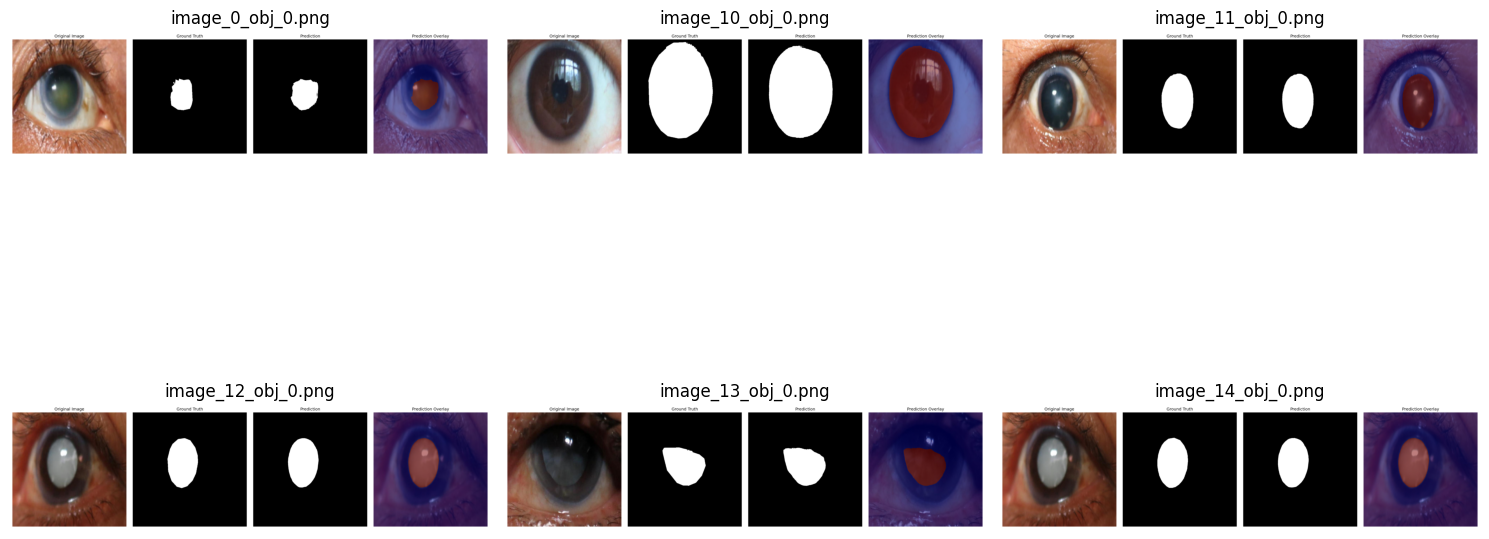

In [25]:
# Visualizar algunas predicciones
import matplotlib.pyplot as plt
from PIL import Image
import os

viz_dir = "inference_results/visualizations"
images = sorted([f for f in os.listdir(viz_dir) if f.endswith('.png')])[:6]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for idx, img_name in enumerate(images):
    img = Image.open(os.path.join(viz_dir, img_name))
    axes[idx//3, idx%3].imshow(img)
    axes[idx//3, idx%3].axis('off')
    axes[idx//3, idx%3].set_title(img_name)

plt.tight_layout()
plt.show()

## 1️⃣3️⃣ Descargar Checkpoints

In [ ]:
# Comprimir checkpoints para descargar
!zip -r sam_lora_checkpoints.zip "/content/drive/MyDrive/SAM_LoRA_Training/outputs/*/checkpoints"

# Descargar desde Colab
from google.colab import files
files.download('sam_lora_checkpoints.zip')

## 📊 Tips para Optimizar en Colab

### Memoria GPU:
- **T4 (15GB)**: `batch_size=2-4`, `gradient_accumulation_steps=2-4`
- **A100 (40GB)**: `batch_size=8-16`, `gradient_accumulation_steps=1-2`

### Evitar Desconexiones:
```javascript
// Ejecutar en consola del navegador (F12)
function KeepClicking(){
    console.log("Clicking");
    document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking, 60000)
```